In [5]:
from model.lina import Lina
from dataset import ManifestDataset, ManifestDataModule
import torch
import numpy as np
from matplotlib import pyplot as plt
from vocos import Vocos
from IPython.display import Audio, display
from einops import rearrange, reduce, repeat
from pathlib import Path
from tqdm import tqdm
import pytorch_lightning as ptl
#import phonemizer
import time

In [8]:
%ls -nt ttc/checkpoints/ttc_libritts360clean

total 1971084
lrwxrwxrwx 1 1000 1000       105 14 janv. 19:44  last-v1.ckpt -> '/home/lemerle/lina/ttc/checkpoints/ttc_libritts360clean/checkpoint_epoch=4_step=9900_val_loss=3.5177.ckpt'
-rw-r--r-- 1 1000 1000 388895906 14 janv. 18:35 'checkpoint_epoch=4_step=9900_val_loss=3.5177.ckpt'
-rw-r--r-- 1 1000 1000 388895906 14 janv. 18:25 'checkpoint_epoch=3_step=7920_val_loss=3.5154.ckpt'
-rw-r--r-- 1 1000 1000 388895906 14 janv. 18:15 'checkpoint_epoch=2_step=5940_val_loss=3.5211.ckpt'
lrwxrwxrwx 1 1000 1000       107 14 janv. 12:22  last.ckpt -> '/home/lemerle/lina/ttc/checkpoints/ttc_libritts360clean/checkpoint_epoch=20_step=33789_val_loss=3.1782.ckpt'
-rw-r--r-- 1 1000 1000 283890540 14 janv. 12:22 'checkpoint_epoch=20_step=33789_val_loss=3.1782.ckpt'
-rw-r--r-- 1 1000 1000 283890540 14 janv. 12:14 'checkpoint_epoch=19_step=32180_val_loss=3.1840.ckpt'
-rw-r--r-- 1 1000 1000 283890540 14 janv. 12:06 'checkpoint_epoch=18_step=30571_val_loss=3.1879.ckpt'


In [45]:
#model = TTC.load_from_checkpoint("ttc/checkpoints/ttc_libritts360clean/last-v11.ckpt").cuda().train(True)
model = Lina.load_from_checkpoint("ttc/checkpoints/ttc_libritts360clean/last.ckpt").cuda().train(True)

vocos = Vocos.from_pretrained("charactr/vocos-encodec-24khz").cuda()

/home/lemerle/miniforge3/envs/torch/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'attentive_rnn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['attentive_rnn'])`.
/home/lemerle/miniforge3/envs/torch/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'txt_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['txt_encoder'])`.
/home/lemerle/miniforge3/envs/torch/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [46]:
def vocos_code_to_wav(code, bandwidth):
    feat = vocos.codes_to_features(code)
    return vocos.decode(feat, bandwidth_id=torch.tensor(bandwidth, device=code.device))

def to_vocos(x):
    x = torch.stack(x)
    x = undelay_rvq(x.T)
    x = (x - 1).clamp_min(0)
    return x
    
def undelay_rvq(extended_code):
    q, _ = extended_code.shape
    for i in range(q):
        extended_code[i, :] = torch.roll(extended_code[i, :], -(i + 1))
    return extended_code[:, :-(q+1)]

def txt_to_phon(x):
    return espeak.phonemize([x], strip=True, njobs=1)[0]
    
def phon_to_code(x):
    y = [ds.vocab_x_code[t] for t in x]
    y = [ds.vocab_x_code["BOS"]] + y + [ds.vocab_x_code["EOS"]]
    return torch.tensor(y)

In [47]:
datamodule = ManifestDataModule(
                    env_root="DBROOT",
                    root_path="LibriTTS/feats_train-clean-360",
                    train_manifest_path="simplettsdataset/libritts_train-clean-360_ttc_length.json",
                    symbols_file="symbols.txt",
                    quant_layer=[0,1,2,3],
                    phon_col=".phonemized.txt",
                    #metadata_col=["speaker", "book", "sentence", ".normalized.txt"],
                    filter_min=800,
                    batch_size=1,
                    )
datamodule.setup("")
dl = iter(datamodule.train_dataloader())

SYMBOLS:  ['̩', 'ˈ', 'x', 'r', 'v', 'ʃ', '̃', 'ː', 'b', 'ʲ', 'l', 'o', 'e', '—', 'ᵻ', 'ɡ', 'ɐ', 'u', '?', 'w', 'ɚ', ',', 'ɑ', 'n', 'ˌ', 'æ', ' ', 'p', 'z', 'ɹ', 'ɜ', 'ɬ', 'ɔ', 't', 'a', 'ð', 'ʌ', 's', '.', 'ɾ', 'j', 'ɛ', ';', 'ɪ', 'd', 'm', 'ʊ', 'ʔ', 'ə', 'θ', 'i', 'ʒ', '!', 'f', ':', '"', 'h', 'k', 'ç', 'ŋ', '“', '”']


In [1]:
model = model.train(False)
dir = Path("eval_test_clean_prompt")
dir.mkdir(exist_ok=True)

prompt_len = 225 #3s
#sample
batch = next(dl)
x, y, x_len, y_len, code, phon, metadata = map(lambda x: x.cuda() if hasattr(x, "cuda") else x, batch)

#metadata = metadata[0]
#metadata[".normalized.txt"] = open(datamodule.root_path/metadata[".normalized.txt"], "r").read()

qs, atts_hat = model.generate(x[0],
                              device="cuda",
                              k=200,
                              temp=1.,
                              max_seqlen=2000,
                              prompt=y[:,:prompt_len],
                             )

wav = vocos_code_to_wav(to_vocos(qs), 2)
wav_orig = vocos_code_to_wav(code[0].cuda(), 2)

fig = plot_atts(atts_hat.numpy(force=True)[0])
fig.suptitle(metadata)
fig.show()


Audio(wav_orig.cpu(), rate=24000)
Audio(wav.cpu(), rate=24000)

NameError: name 'model' is not defined

In [9]:
import polars as pl
import os
from random import choice
from pathlib import Path
manifest = pl.read_json(Path(os.environ["DBROOT"])/"simplettsdataset/libritts_feats_test-clean_manifest_length.json")
df = manifest.tail(-1).with_row_count().select(["row_nr","speaker","length"])
speakers = [spk for spk in df.partition_by("speaker") if len(spk)>1]

In [10]:
prompt_datamodule = ManifestDataModule(
                    env_root="DBROOT",
                    root_path="LibriTTS/LibriTTS/feats_test-clean",
                    train_manifest_path="simplettsdataset/libritts_feats_test-clean_manifest_length.json",
                    symbols_file="symbol.txt",
                    quant_layer=[0,1,2,3],
                    phon_col=".normalized.phonemized.txt",
                    metadata_col=["speaker", "book", "chapter", "sentence", ".normalized.txt"],
                    #filter_min=800,
                    batch_size=1,
                    val_dataset_size=1,
                    )
prompt_datamodule.setup("")
dl_prompt = iter(datamodule.train_dataloader())

SYMBOLS:  ['̩', 'ˈ', 'x', 'r', 'v', 'ʃ', '̃', 'ː', 'b', 'ʲ', 'l', 'o', 'e', '—', 'ᵻ', 'ɡ', 'ɐ', 'u', '?', 'w', 'ɚ', ',', 'ɑ', 'n', 'ˌ', 'æ', ' ', 'p', 'z', 'ɹ', 'ɜ', 'ɬ', 'ɔ', 't', 'a', 'ð', 'ʌ', 's', '.', 'ɾ', 'j', 'ɛ', ';', 'ɪ', 'd', 'm', 'ʊ', 'ʔ', 'ə', 'θ', 'i', 'ʒ', '!', 'f', ':', '"', 'h', 'k', 'ç', 'ŋ', '“', '”']


In [53]:
model = model.train(False)
dir = Path("eval_nopba")
dir.mkdir(exist_ok=True)

codec_rate_hz = 75
metadata = []
#prompt_len = 5*codec_rate_hz
N = 40
for i in tqdm(range(N)):
    
    #sample a speaker then 2 samples with correct lengths
    while True:
        speaker = choice(speakers)
        sample = speaker.select("row_nr", "length").sample(2).to_dict(as_series=False)
        prompt_l, target_l = sample["length"]
        prompt, target = sample["row_nr"]
        if prompt_l > target_l:
            prompt, target = target, prompt
            prompt_l, target_l = target_l, prompt_l
        if prompt_l > 3*codec_rate_hz and (prompt_l + target_l) < 15*codec_rate_hz:
            break
            
    batch_prompt = prompt_datamodule.train_dataset[prompt]
    batch_target = prompt_datamodule.train_dataset[target]
    x_target, _, code_target, phon_target, metadata_target = map(lambda x: x.cuda() if hasattr(x, "cuda") else x, batch_target)
    x_prompt, y, code_prompt, phon_prompt, metadata_prompt = map(lambda x: x.cuda() if hasattr(x, "cuda") else x, batch_prompt)

    #dirty fix, fsr ".normalized.txt" randomly pops out
    metadata_prompt = manifest.filter(**metadata_prompt).select("speaker", "book", "chapter", "sentence", ".normalized.txt").row(0, named=True)
    metadata_target = manifest.filter(**metadata_target).select("speaker", "book", "chapter", "sentence", ".normalized.txt").row(0, named=True)
    
    x = torch.cat((x_prompt[:-1], x_target[1:]))
    start = time.perf_counter()
    qs, atts_hat = model.generate(x,
                                  device="cuda",
                                  k=200,
                                  temp=1.,
                                  max_seqlen=2000,
                                  prompt=y.unsqueeze(0)[:,:-20],
                                 )
    stop = time.perf_counter()
    rtf = (len(qs)/codec_rate_hz)/(stop-start)
    print(f"RTF : {rtf}")
    #save
    with open(datamodule.root_path/metadata_prompt[".normalized.txt"], "r") as f:
        text_prompt = f.read()
        
    with open(datamodule.root_path/metadata_target[".normalized.txt"], "r") as f:
        text_target = f.read()
    
    
    with open(dir/(str(i)+"_prompt.txt"), "w") as f:
        f.write(text_prompt)
    with open(dir/(str(i)+"_target.txt"), "w") as f:
        f.write(text_target)

    crop = code_prompt.shape[1]
    wav = vocos_code_to_wav(to_vocos(qs)[:,crop:], 1)
    wav_prompt = vocos_code_to_wav(code_prompt.cuda(), 1)
    wav_target = vocos_code_to_wav(code_target.cuda(), 1)
    
    fig = plot_atts(atts_hat.numpy(force=True)[0])
    fig.suptitle(str(i))
    fig.savefig(dir/(str(i)+".png"))
    plt.close(fig)
    
    with open(dir/(str(i)+"_synth.wav"), "wb") as f:
        f.write(Audio(wav.cpu(), rate=24000).data)
    with open(dir/(str(i)+"_prompt.wav"), "wb") as f:
        f.write(Audio(wav_prompt.cpu(), rate=24000).data)
    with open(dir/(str(i)+"_target.wav"), "wb") as f:
        f.write(Audio(wav_target.cpu(), rate=24000).data)
        
    metadata_prompt = {k+"_prompt" : v for k, v in metadata_prompt.items()}
    metadata_target = {k+"_target" : v for k, v in metadata_target.items()}
    metadata.append(pl.from_dict({**metadata_prompt,**metadata_target, **{"text_prompt": text_prompt, "text_target": text_target}}))
    
pl.concat(metadata).write_json(dir/"metadata.json")

  2%|██▎                                                                                        | 1/40 [00:06<04:23,  6.74s/it]

RTF : 1.7348738989750805


  5%|████▌                                                                                      | 2/40 [00:13<04:23,  6.93s/it]

RTF : 1.8988041283772794


  8%|██████▊                                                                                    | 3/40 [00:20<04:18,  6.98s/it]

RTF : 1.8395907280259678


 10%|█████████                                                                                  | 4/40 [00:27<04:07,  6.87s/it]

RTF : 1.7061720857003477


 12%|███████████▍                                                                               | 5/40 [00:34<04:06,  7.05s/it]

RTF : 1.8819816600612747


 15%|█████████████▋                                                                             | 6/40 [00:43<04:20,  7.65s/it]

RTF : 1.8860700758429279


 18%|███████████████▉                                                                           | 7/40 [00:51<04:16,  7.78s/it]

RTF : 1.892986634419923
RTF : 1.8885311297016556


 22%|████████████████████▍                                                                      | 9/40 [01:06<03:46,  7.32s/it]

RTF : 1.8303511300749868


 25%|██████████████████████▌                                                                   | 10/40 [01:11<03:18,  6.61s/it]

RTF : 1.9208003135384264


 28%|████████████████████████▊                                                                 | 11/40 [01:18<03:20,  6.93s/it]

RTF : 1.8845052586533204


 30%|███████████████████████████                                                               | 12/40 [01:25<03:11,  6.85s/it]

RTF : 1.9011149349390977


 32%|█████████████████████████████▎                                                            | 13/40 [01:32<03:03,  6.79s/it]

RTF : 1.728224645172918


 35%|███████████████████████████████▍                                                          | 14/40 [01:40<03:08,  7.24s/it]

RTF : 1.7613364123477988


 38%|█████████████████████████████████▊                                                        | 15/40 [01:44<02:38,  6.32s/it]

RTF : 1.9074349780865465


 40%|████████████████████████████████████                                                      | 16/40 [01:50<02:32,  6.34s/it]

RTF : 1.9077562669721335


 42%|██████████████████████████████████████▎                                                   | 17/40 [01:59<02:38,  6.90s/it]

RTF : 1.8963330027894179


 45%|████████████████████████████████████████▌                                                 | 18/40 [02:06<02:37,  7.18s/it]

RTF : 1.8878594900709433


 48%|██████████████████████████████████████████▊                                               | 19/40 [02:15<02:37,  7.49s/it]

RTF : 1.886646115226822


 50%|█████████████████████████████████████████████                                             | 20/40 [02:21<02:21,  7.10s/it]

RTF : 1.824728078637318


 52%|███████████████████████████████████████████████▎                                          | 21/40 [02:27<02:10,  6.86s/it]

RTF : 1.9054062198689694


 55%|█████████████████████████████████████████████████▌                                        | 22/40 [02:36<02:13,  7.41s/it]

RTF : 1.9211463905959578


 57%|███████████████████████████████████████████████████▋                                      | 23/40 [02:43<02:05,  7.39s/it]

RTF : 1.8346380589740192


 60%|██████████████████████████████████████████████████████                                    | 24/40 [02:51<02:00,  7.55s/it]

RTF : 1.9032763075222479


 62%|████████████████████████████████████████████████████████▎                                 | 25/40 [02:56<01:43,  6.90s/it]

RTF : 1.9168176380094835


 65%|██████████████████████████████████████████████████████████▌                               | 26/40 [03:02<01:30,  6.47s/it]

RTF : 1.8575681752794524


 68%|████████████████████████████████████████████████████████████▊                             | 27/40 [03:09<01:27,  6.70s/it]

RTF : 1.934678435754023
RTF : 1.952615796253344


 72%|█████████████████████████████████████████████████████████████████▎                        | 29/40 [03:24<01:14,  6.82s/it]

RTF : 1.8578915164026835


 75%|███████████████████████████████████████████████████████████████████▌                      | 30/40 [03:30<01:06,  6.62s/it]

RTF : 1.890471838204086


 78%|█████████████████████████████████████████████████████████████████████▊                    | 31/40 [03:38<01:02,  6.98s/it]

RTF : 1.922691035437387
RTF : 1.9333757767250817


 82%|██████████████████████████████████████████████████████████████████████████▎               | 33/40 [03:51<00:46,  6.63s/it]

RTF : 1.946214540497357


 85%|████████████████████████████████████████████████████████████████████████████▌             | 34/40 [03:59<00:42,  7.01s/it]

RTF : 1.8346283930395095


 88%|██████████████████████████████████████████████████████████████████████████████▊           | 35/40 [04:03<00:30,  6.18s/it]

RTF : 1.916247008396511


 90%|█████████████████████████████████████████████████████████████████████████████████         | 36/40 [04:08<00:23,  5.85s/it]

RTF : 1.941940837946839


 92%|███████████████████████████████████████████████████████████████████████████████████▎      | 37/40 [04:16<00:19,  6.61s/it]

RTF : 1.8441956622568043


 95%|█████████████████████████████████████████████████████████████████████████████████████▌    | 38/40 [04:21<00:12,  6.15s/it]

RTF : 1.9085075803163185


 98%|███████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [04:29<00:06,  6.57s/it]

RTF : 1.9089748132184936


100%|██████████████████████████████████████████████████████████████████████████████████████████| 40/40 [04:36<00:00,  6.91s/it]

RTF : 1.9125115199291163


[tensor(0.6972, device='cuda:0'), tensor(0.6678, device='cuda:0'), tensor(0.6525, device='cuda:0'), tensor(0.5813, device='cuda:0')]


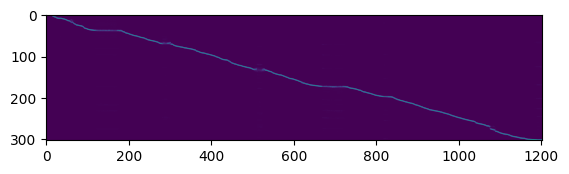

In [56]:
model = model.train(False)
#model.attention.loc_fn.lag = 0
batch = next(dl)
batch = tuple(map(lambda x: x.cuda() if hasattr(x, "cuda") else x, batch))
with torch.no_grad():
    x, y, x_len, y_len, code, phon, metadata = batch
    logits_orig, loss, atts, acc = model(x, y, x_len, y_len)
print(acc)
plt.imshow(atts.numpy(force=True)[0,1].T)